In [29]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [30]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
#import statsmodels.api as sm
import pylab 
import itertools
import codes.GPUCB_Bio
from collections import defaultdict

%matplotlib inline

In [31]:
df = pandas.read_csv('../data/trainset.rbs1.v2.csv', delimiter=',')

In [32]:
df.head()

,Construct,Barcode,rbs1_1_A,rbs1_1_C,rbs1_1_G,rbs1_1_T,rbs1_2_A,rbs1_2_C,rbs1_2_G,rbs1_2_T,...,rbs2_3_A,rbs2_3_C,rbs2_3_G,rbs2_3_T,Group,ODind,ODhar,FC,rbs1,rbs2
0,RBS629,77DD32,0,0,1,0,0,0,1,0,...,0,0,1,0,Top,0.410,4.523,1.437982,GGG,GGG
1,RBS678,77DD39,0,0,1,0,0,0,1,0,...,0,0,1,0,Top,0.359,2.678,1.277175,GGG,GGG
2,RBS353,77DD18,0,0,1,0,0,0,1,0,...,0,0,1,0,Top,0.334,1.745,1.545141,GGC,GGG
3,RBS403,77DD20,0,0,1,0,0,0,1,0,...,1,0,0,0,Top,0.390,2.166,1.670098,GGC,GGA
4,RBS500,77DD24,0,0,1,0,0,0,1,0,...,0,1,0,0,Top,0.375,2.348,1.621230,GGC,GGC


(array([15.,  6.,  3.,  3.,  2.,  3.,  9.,  8.,  9.,  2.]),
 array([0.09209599, 0.27372471, 0.45535343, 0.63698214, 0.81861086,
        1.00023958, 1.18186829, 1.36349701, 1.54512572, 1.72675444,
        1.90838316]),
 <a list of 10 Patch objects>)

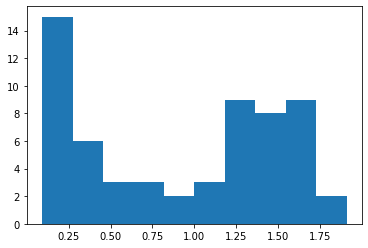

In [33]:
plt.hist(df['FC'])

In [38]:
data = df[['rbs1', 'FC']].to_numpy()

In [40]:
data[:, 0].shape

(60,)

### Independence test

In [5]:
# create rewards sampels from training set

rbs1 = df['rbs1']
rbs2 = df['rbs2']
rbs1_u = rbs1.unique()
rbs2_u = rbs2.unique()

rewards_dict = defaultdict(list) # keys: rbs1+rbs2 string; values: list of FCs 
sorted_rewards_dict = defaultdict(list) 
arms = [] # e.g. 'AACGTC'
arms_encoding = [] # e.g. '100010000100001000010100'

for i in rbs1_u:
    for j in rbs2_u:
        values = list(df.loc[df['rbs1'] == i].loc[df['rbs2'] ==j]['FC'])
        if len(values) > 0:
            rewards_dict[i+j] = values
            arms.append(i+j)
arms = sorted(arms)

for i in arms:
    encodings = ''.join(str(e) for e in list(df.loc[df['rbs1'] ==  i[:3]].loc[df['rbs2'] == i[3:]].iloc[0,2:26]))
    arms_encoding.append(encodings)
    sorted_rewards_dict[i] = rewards_dict[i]

In [6]:
X = np.asarray(rbs1 + rbs2)
Y = np.asarray(df['FC'])

In [7]:

def distance_arms(arm1, arm2):
    assert len(arm1) == len(arm2)
    distance = 0
    for idx in range(len(arm1)):
        if arm1[idx] != arm2[idx]:
            distance += 1
        
    return distance

def chisquare_arms(arm1, arm2):
    return chisquare(rewards_dict[arm1], rewards_dict[arm2])

def abs_diff(arm1, arm2):
    #return np.abs(np.mean(rewards_dict[arm1]) - np.mean(rewards_dict[arm2]))
    r1 = np.mean(rewards_dict[arm1])
    r2 = np.mean(rewards_dict[arm2])
    if r1 < r2:
        return r1/r2
    else:
        return r2/r1
        

In [8]:
from scipy.stats import chisquare

distance_dict = {} # keys: (arm1, arm2), values: (distance of arms, chisquare of arms)
new_dict = defaultdict(list) # keys: distances, values: sequences of scores

distance_list = []
score_list = []

for i, arm_i in enumerate(arms):
    for j, arm_j in enumerate(arms):
        if j > i:
            distance = distance_arms(arm_i, arm_j)
            score = abs_diff(arm_i, arm_j)
            distance_dict[(arm_i, arm_j)] = (distance, score)
            new_dict[distance].append(score)
            distance_list.append(distance)
            score_list.append(score)

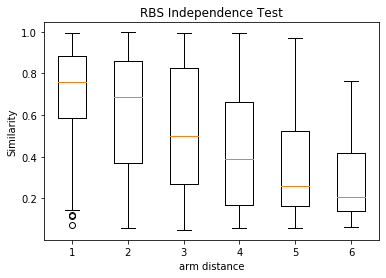

In [9]:
fig, ax = plt.subplots()

new_list = []

for key, value in new_dict.items():
    new_list.append(value)
ax.boxplot(new_list)

plt.title('RBS Independence Test')
plt.xlabel('arm distance')
plt.ylabel('Similarity')
plt.savefig('RBS_Independence_Test.png')

The xlabel is the arm distance, which is between 0 and 6, counting by the number of different letters of each pair of RBS. ylabel is FC distance, which is the ratio between each arms' corresponding FC score (keeping ratios smaller than one (big one/small one), which is the similarity (approaching one means more similar).) The less the arm distance is, the more similar the FC it gets, which shows the RBS is relevant in terms of expressing FC.

## Kernels

If there is some similarity between arms, then we can make use of that to do some ML on that. But before that, we need to figure out how to represent the similarities and which approach is our best choice. There are some candidate kernel methods: Linear, RBF, and some designed for bio sequences (mismatch kernel, ...)

### Mismatch Kernel

In [10]:
from mismatch_kernel import MismatchKernel
from mismatch_kernel import preprocess

In [11]:
l = 4 # for DNA/RNA sequence data
k = 5 # for k-mers (substring of length k) 
m = 2 # maximum number of mismatches for 2 k-mers to be considered ‘similar’.



X_kernel = MismatchKernel(l=l, k=k, m=m).get_kernel(preprocess(X)).kernel

X_train, X_test, y_train, y_test = train_test_split(X_kernel, Y, test_size=0.2, random_state=42)
X_train_kernel = X_train.dot(X_train.T)
X_test_kernel = X_test.dot(X_train.T)

In [12]:
X_test_kernel.shape

(12, 48)

In [13]:
from sklearn.kernel_ridge import KernelRidge

reg = KernelRidge(kernel = 'precomputed')
reg.fit(X_train_kernel, y_train)
train_prediction = reg.predict(X_train_kernel)
test_prediction = reg.predict(X_test_kernel)
print('train score: ', reg.score(X_train_kernel, y_train))
print('test score: ', reg.score(X_test_kernel, y_test))

train score:  0.8175450173227851
test score:  0.6364913589969539


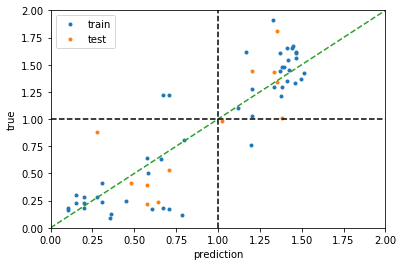

In [14]:
plt.plot(train_prediction, y_train, '.', label = 'train')
plt.plot(test_prediction, y_test, '.', label = 'test')
plt.plot([0,2], [0,2], '--')
plt.plot([0,2], [1,1], 'k--')
plt.plot([1,1], [0,2], 'k--')
plt.xlabel('prediction')
plt.ylabel('true')
plt.xlim(0,2)
plt.ylim(0,2)
plt.legend()

### Gappy-Pair Kernel

In [15]:
from strkernel.gappy_kernel import gappypair_kernel as gk
from strkernel.gappy_trie import gappypair_kernel as gt

In [16]:
X_kernel = gk(X, k =1, t = 0, g =1).toarray()

X_train, X_test, y_train, y_test = train_test_split(X_kernel, Y, test_size=0.2, random_state=42)
X_train_kernel = X_train.dot(X_train.T)
X_test_kernel = X_test.dot(X_train.T)

In [17]:
reg = KernelRidge(kernel = 'precomputed')
reg.fit(X_train_kernel, y_train)
train_prediction = reg.predict(X_train_kernel)
test_prediction = reg.predict(X_test_kernel)
print('train score: ', reg.score(X_train_kernel, y_train))
print('test score: ', reg.score(X_test_kernel, y_test))


train score:  0.7812124696879327
test score:  0.6035201596217032


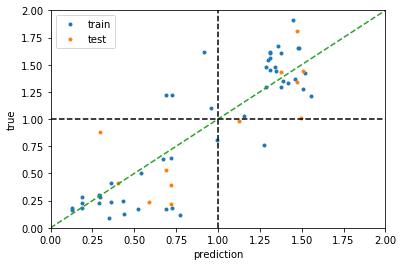

In [18]:
plt.plot(train_prediction, y_train, '.', label = 'train')
plt.plot(test_prediction, y_test, '.', label = 'test')
plt.plot([0,2], [0,2], '--')
plt.plot([0,2], [1,1], 'k--')
plt.plot([1,1], [0,2], 'k--')
plt.xlabel('prediction')
plt.ylabel('true')
plt.xlim(0,2)
plt.ylim(0,2)
plt.legend()

## GP-UCB

Viewing rbs1 and rbs2 as a string of length 6, each letter cound be one of the "A", "C", "G", "T", then there are totoally $4^6 = 4096$ choices (arms). However, for training dataset we only get 43 choices of rbs1 + rbs2.

So for this experiment, our assumption is we have 43 choices (arms), the distributions behind each arm is unknown but can be sampled from the sample set given from the training dataset (1 to 3 samples for each arm). The distributions are stored in a dictionary, with the string 'rbs1 + rbs2' as keys and a list of the sample rewards as values. Note the for each arm, the number of samples is different. Different samples are sampled with equal probablity (again, break the normal noise assumption here). The best arm is the arm with the highest average sample reward. We only initialise 10 arms randomly, otherwise we will know most of samples (considering that each arm only has one to three samples) before running the algorithm. 

We assume the arms are dependent (strings with small distance has big similarities), we use kernel to model the similarities (smoothness). 

Some choices of kernels are:

* linear kernel
* rbf 
* spectrum kernel (model sequences)

TODO: However, I think it's important to apply biology knoweledge into modelling, e.g. what is the relationship between "AAC" and "AAG"?

For now, let's use linear kernels to model GPs and illustrates an example. 

Issues: 

* we don't know the best actions! How do we evaluate regret?
* the reward distribution of each arm is a ratio and not gaussian (see qqplot above), which breaks our GP assumption. Can we convert?
* how to initialise? initalise once for each arm? I think it's ok to just random initially sample a subset, since we have too much arms (4096) and arms are dependent. 

Show: the objective, posterior mean and variance, acquisition function (maybe dynamic)

In [15]:
num_arms = len(rewards_dict.keys())

print('There are totoally', num_arms, 'unique combinations of rbs1 and rbs2.')

class rewards_env():
    def __init__(self, rewards_dict):
        self.rewards = rewards_dict
        
    def decoding(self, code):
        """decoding arms: from one-hot encoding to strings
        
        code: list of one hot encoding
        
        Return: string
        """
        return ''.join(str(e) for e in code)   
        
    def sample(self, idx):
        prob = np.random.uniform(0,1)
        idx = self.decoding(idx)
        my_range = np.arange(0, 1, 1.0/len(self.rewards[idx]))
    
        for i in range(len(my_range)):
            if i == len(my_range) - 1 and prob >= my_range[i]:
                return self.rewards[idx][i]
            elif prob >= my_range[i] and prob < my_range[i+1]:
                return self.rewards[idx][i]
            
    def sample_withoutnoise(self, idx):
        return np.mean(self.rewards[idx])
        

There are totoally 43 unique combinations of rbs1 and rbs2.


In [ ]:
num_exper = 10
num_round = 10
num_init = 10   
env = rewards_env(sorted_rewards_dict)

Parameter a =  0.5


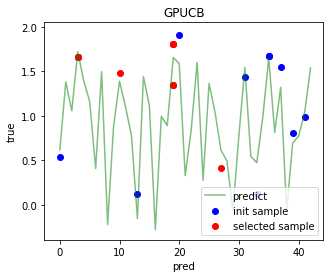

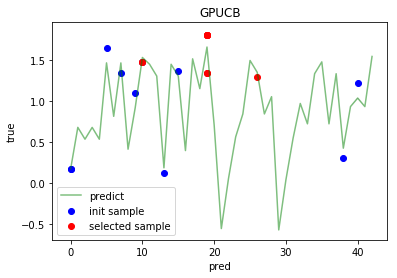

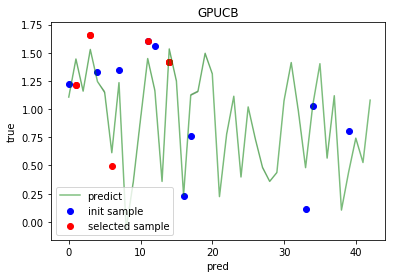

In [ ]:
#%%capture

import warnings
warnings.filterwarnings('ignore')

#a_list = np.arange(1,10) * 0.1
a_list = [0.5]

f = plt.figure(figsize=(5, 4 * len(a_list)))

for i, a in enumerate(a_list):
    plt.subplot(len(a_list), 1, i+1)
    print('Parameter a = ', a)
    regrets = []
    for e in range(num_exper):
        init_list = np.random.randint(0,len(arms),num_init)
        gpucb = GPUCB_Bio.GPUCB(env, arms, arms_encoding, num_round, init_list, delta = a)
        gpucb.play()
        regrets.append(gpucb.regret_list)
        gpucb.plot()

    regrets = np.asarray(regrets).reshape((num_exper, num_round))
    ave_regrets = np.mean(regrets, axis = 0)
    plt.xlabel('iteration')
    plt.ylabel('regret')
    plt.plot(range(len(ave_regrets)), ave_regrets)